### Preprocessing the raw data

Since the data is all categorical values and we want to preserve the data in terms of integers, we will use manual Ordinal-Encoding as our method of converting categorical features to numerical features.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score


df = pd.read_csv('responses.csv')

emails = df['Email'].values # if user entered email, email them their recommendations
study_data = df.drop(['Timestamp', 'Email'], axis=1) # timestamp and email is irrelevant for information
study_data.columns = study_data.columns.str.strip()

def create_ordinal_mapping(categories):
    # assigns a numeric value starting from 0 to each category in the list
    # those with lower scores are associated with poorer study habits and vice versa
    return {category: index for index, category in enumerate(categories)}

ordinal_maps = {
    'Age' : create_ordinal_mapping(['Under 18', '22 - 30', '31+', '18 - 21']),
    'Education Level': create_ordinal_mapping(['Other', 'High School', 'Trade/Vocational', 'Undergraduate', 'Graduate']),
    'Number of Courses': create_ordinal_mapping(['1 - 2', '3 - 4', '5+']),
    'Hours of Sleep': create_ordinal_mapping(['Less than 4 hours', '4 - 5 hours', '6 - 7 hours', '8+ hours']),
    'Time of Sleep': create_ordinal_mapping(['After 12 AM', '11 - 12 AM', '10 - 11 PM', 'Before 10 PM']),
    'Hours of Part-Time Job': create_ordinal_mapping(['Yes, more than 20 hours per week', 
                                                     'Yes, 10 - 20 hours per week', 
                                                     'Yes, less than 10 hours per week', 
                                                     'No, I am currently not working']),
    'Number of Extracurricular Activities': create_ordinal_mapping(['0 activities', 
                                                                  '1 - 2 activities', 
                                                                  '3 - 4 activities', 
                                                                  'More than 4 activities']),
    'Hours of Studying': create_ordinal_mapping(['Less than one hour', '1 - 2 hours', 
                                                '3 - 4 hours', 'More than 4 hours']),
    'Break Frequency': create_ordinal_mapping(['I rarely take breaks', 'Every 1 - 2 hours', 
                                               'Every 30 minutes - 1 hour', 'Every 15 - 30 minutes']),
    'Focus Methods': create_ordinal_mapping(['Reward System (small breaks or treats after tasks)', 'Silence', 'Background Music', 'Pomodoro Technique (study in short bursts with breaks)']),
    'Challenge when Studying': create_ordinal_mapping(['Not enough time to study', 'Procrastination', 
                                                      'Lack of motiviation', 'Difficulty staying focused', 
                                                      'Trouble understanding the material']),
    'Distraction Frequency': create_ordinal_mapping(['Very Often (I constantly get distracted and lose focus)', 
                                                     'Often (I struggle to concentrate for long periods)', 
                                                     'Sometimes (I get distracted, but can refocus easily)',
                                                     'Rarely (I stay focused most of the time)']),
    'Resources if Stuck': create_ordinal_mapping(['Skip it and move on', 'Figure it out myself', 
                                                 'Use online resources (YouTube, Khan Academy, etc.)', 
                                                 'Ask a classmate or friend', "Visit the professor's office hours"]),
    'Study Motivation': create_ordinal_mapping(['Fear of failing a class', 
                                                'Desire to get good grades',
                                                'Pressure from friends, family, and teachers',
                                                'Interest in learning the subject', 
                                                'Career or future goals']),
    'Current Study Habits Rating': create_ordinal_mapping(["Ineffective (I feel lost and don't know how to improve)", 
                                                          'Not very effective (I struggle to stay consistent or motivated)', 
                                                          'Somewhat effective (I get my work done, but there is room for improvement)', 
                                                          'Very effective (I rarely struggle with studying)']),
}
study_data['Study Methods'] = study_data['Study Methods'].apply(lambda x: len(x.split(',')) if x != '' else 0)
for column, mapping in ordinal_maps.items():
    if column in study_data.columns:
        study_data[column] = study_data[column].map(mapping)
        
print(study_data)



    Age  Education Level  Number of Courses  Hours of Sleep  Time of Sleep  \
0     3                3                  1               3              0   
1     3                3                  1               2              1   
2     3                3                  2               1              0   
3     3                3                  1               1              0   
4     3                3                  1               2              1   
5     3                3                  2               2              0   
6     3                3                  1               1              0   
7     1                1                  1               2              0   
8     1                3                  1               2              0   
9     3                4                  2               3              3   
10    3                3                  1               2              0   
11    3                1                  2               2     

### Clustering the data and predicting the students' clusters based on their study data using K-Nearest Neighbors.

First, we want to cluster the data together so there are 4 clusters based on the students' study habits and other demographics. Each student is grouped based on their study habits to the corresponding cluster and these will be the TARGET labels.

Then, we wil use K-Nearest Neighbor (KNN) to make predictions about a new student's clusters based on the student data. After training KMeans to group students, we are using KNN to classify a new student's study habits into one of the existing clusters based on their similarity to the known clusters.

In [5]:
scaler = StandardScaler()
scaled_study_data = scaler.fit_transform(study_data)

kmeans = KMeans(n_clusters=4, random_state=42)
study_data['Cluster'] = kmeans.fit_predict(scaled_study_data) # new column called 'Cluster' that represents what cluster each student is in
print(study_data['Cluster'])

X = study_data.drop(columns=['Cluster']) 
y = study_data['Cluster']  # target column (Cluster)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3, weights = 'distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Adjusted Rand Score', adjusted_rand_score(y_test, y_pred))

0     2
1     0
2     0
3     3
4     2
5     0
6     0
7     3
8     2
9     1
10    2
11    3
12    0
13    0
14    0
Name: Cluster, dtype: int32
Adjusted Rand Score 0.6153846153846154


### Plotting the data

Here, we 

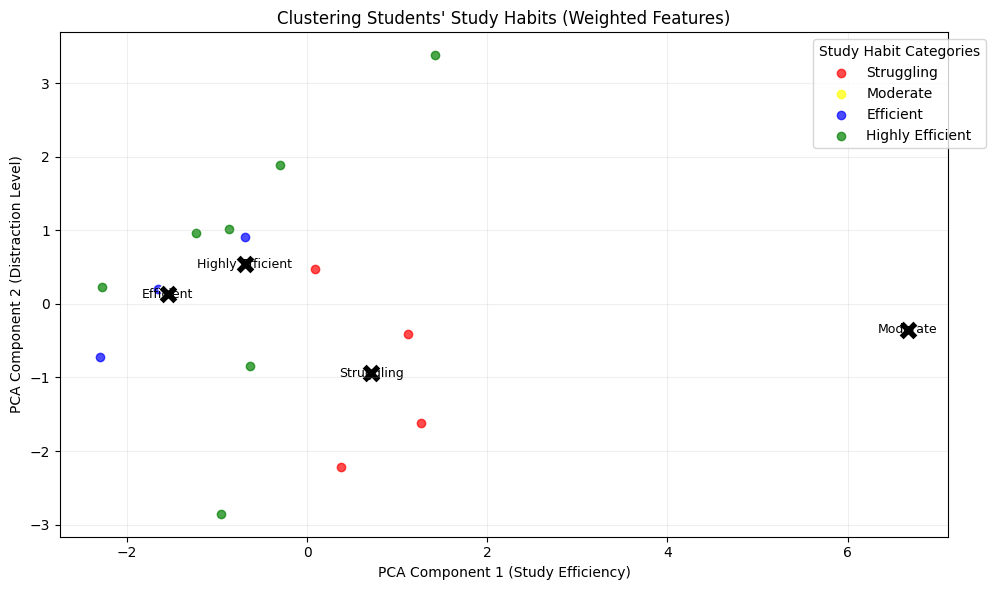

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_study_data)

def assign_cluster_labels_by_quality(data): # labels each cluster based on study habit quality
    # calculate a composite "Struggle Score" (higher = worse habits)
    data['Struggle_Score'] = (
        0.4 * (max(data['Current Study Habits Rating']) - data['Current Study Habits Rating']) + 
        0.3 * data['Distraction Frequency'] + 
        0.2 * data['Challenge when Studying'] + 
        0.1 * (max(data['Hours of Studying']) - data['Hours of Studying'])
    )
    cluster_means = data.groupby('Cluster')['Struggle_Score'].mean()
    sorted_clusters = cluster_means.sort_values().index.tolist()
    categories = ['Highly Efficient', 'Efficient', 'Moderate', 'Struggling']
    return {cluster: label for cluster, label in zip(sorted_clusters, categories)}

cluster_labels = assign_cluster_labels_by_quality(study_data)
label_colors = {
    'Struggling': 'red',
    'Moderate': 'yellow',
    'Efficient': 'blue',
    'Highly Efficient': 'green'
}

study_data['Cluster Label'] = study_data['Cluster'].map(cluster_labels)
study_data['Color'] = study_data['Cluster Label'].map(label_colors)

plt.figure(figsize=(10, 6))
for label, color in label_colors.items():
    cluster_data = pca_result[study_data['Cluster Label'] == label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=color, label=label, alpha=0.7)

# Add cluster centroids
for label in label_colors.keys():
    centroid = pca_result[study_data['Cluster Label'] == label].mean(axis=0)
    plt.scatter(centroid[0], centroid[1], marker='X', s=200, c='black', edgecolors='white')
    plt.text(centroid[0], centroid[1], label, fontsize=9, ha='center', va='center')

plt.legend(title="Study Habit Categories", bbox_to_anchor=(1.05, 1))
plt.title('Clustering Students\' Study Habits (Weighted Features)')
plt.xlabel('PCA Component 1 (Study Efficiency)')
plt.ylabel('PCA Component 2 (Distraction Level)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()